In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import lhsmdu
import time

In [2]:
from matplotlib import rcParams
rcParams.update({
    "font.size": 14})

## Load in FEM Validation Data

In [3]:
burgers = scipy.io.loadmat('matlab/burgers.mat')
X_ = torch.from_numpy(burgers['X']).reshape(-1).float()
T_ = torch.from_numpy(burgers['T']).reshape(-1).float()
u_ = torch.from_numpy(burgers['u']).reshape(-1).float()
X_.requires_grad = True
T_.requires_grad = True
xmin = X_.min()
xmax = X_.max()
N_x = X_.shape[0]

In [4]:
u_ = u_.reshape(X_.shape[0], T_.shape[0])

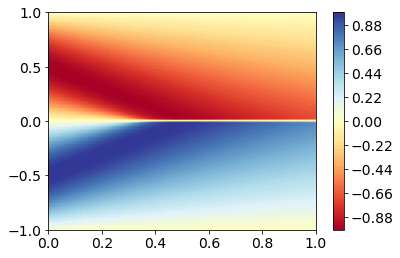

In [5]:
## Evaluate network
x_, t_ = torch.meshgrid(X_, T_)
plt.contourf(t_.detach(), x_.detach(), u_.detach(), levels=100, cmap='RdYlBu')
plt.colorbar()
plt.show()

In [6]:
x_eval = x_.reshape(-1, 1)
t_eval = t_.reshape(-1, 1)

## Create collocation points

In [7]:
nu = 1/(100*torch.tensor(np.pi))
_u_i = lambda x: -torch.sin(torch.tensor(np.pi)*x)
_u_b = lambda t: 0*t

In [8]:
n = 20 # Number of data points in each dimension
n_i = 10 # number of initial points
n_b = 10 # number of boundary points
xmin = -1
xmax = 1

In [9]:
def uniform(n, n_i, n_b):
    n_x = n # Number of data points in interior domain
    n_t = n

    # Interior of domain
    X = torch.linspace(xmin, xmax, n_x+2, requires_grad=True)[1:-1]
    T = torch.linspace(0, 1, n_t+1, requires_grad=True)[1:]
    x, t = torch.meshgrid((X, T))
    x = x.reshape(-1, 1)
    t = t.reshape(-1, 1)

    # Initial
    x_i = torch.linspace(xmin, xmax, n_i,requires_grad=True).reshape(-1, 1)[1:-1]
    t_i = torch.zeros(x_i.shape, requires_grad=True)
    u_i = _u_i(x_i)

    # Boundary
    x_b = torch.cat((xmin*torch.ones(n_b, 1, requires_grad=True),
                     xmax*torch.ones(n_b, 1, requires_grad=True)))
    t_b = torch.cat((torch.linspace(0, 1, n_b, requires_grad=True),
                    torch.linspace(0, 1, n_b, requires_grad=True)), dim=0).reshape(-1, 1)
    u_b = _u_b(t_b)

    return x, t, x_i, t_i, u_i, x_b, t_b, u_b


In [10]:
def hypercube(n, n_i, n_b):
    cube = lhsmdu.sample(2, n*n)
    x = torch.from_numpy(cube[0, :]).reshape(-1, 1)*(xmax-xmin) + xmin
    t = torch.from_numpy(cube[1, :]).reshape(-1, 1)
    x = x.float()
    t = t.float()
    x.requires_grad = True
    t.requires_grad = True
    
    # initial
    x_i = torch.from_numpy(lhsmdu.sample(1, n_i)[0, :]).reshape(-1, 1)*(xmax - xmin) + xmin
    x_i.requires_grad=True
    x_i = x_i.float()
    t_i = torch.zeros(x_i.shape, requires_grad=True)
    u_i = _u_i(x_i)
    
    # boundary
    x_b = torch.cat((xmin*torch.ones(n_b, 1, requires_grad=True),
                     xmax*torch.ones(n_b, 1, requires_grad=True))).float()
    t_b = torch.from_numpy(lhsmdu.sample(1, n_b)[0, :]).reshape(-1, 1)
    t_b = torch.cat((t_b, t_b)).float()
    t_b.requires_grad=True
    u_b = _u_b(t_b)
    
    return x, t, x_i, t_i, u_i, x_b, t_b, u_b
    

In [11]:
def random(n, n_i, n_b):
    cube = lhsmdu.createRandomStandardUniformMatrix(2, n*n)
    x = torch.from_numpy(cube[0, :]).reshape(-1, 1)*(xmax-xmin) + xmin
    t = torch.from_numpy(cube[1, :]).reshape(-1, 1)
    x = x.float()
    t = t.float()
    x.requires_grad = True
    t.requires_grad = True
    
    # initial
    x_i = torch.from_numpy(lhsmdu.createRandomStandardUniformMatrix(1, n_i)[0, :]).reshape(-1, 1)*(xmax - xmin) + xmin
    x_i.requires_grad=True
    x_i = x_i.float()
    t_i = torch.zeros(x_i.shape, requires_grad=True)
    u_i = _u_i(x_i)
    
    # boundary
    x_b = torch.cat((xmin*torch.ones(n_b, 1, requires_grad=True),
                     xmax*torch.ones(n_b, 1, requires_grad=True))).float()
    t_b = torch.from_numpy(lhsmdu.createRandomStandardUniformMatrix(1, n_b)[0, :]).reshape(-1, 1)
    t_b = torch.cat((t_b, t_b)).float()
    t_b.requires_grad=True
    u_b = _u_b(t_b)
    
    return x, t, x_i, t_i, u_i, x_b, t_b, u_b
    

## Define the network class

In [13]:
class Net(nn.Module):
    def __init__(self,
        N_in, N_out,
        N_hid = 30, N_layers=3,
        loss_func=nn.MSELoss(),
        learning_rate = 0.01,
        optimizer = optim.Adam,
        act_func=nn.Tanh()
                ):
        
        super(Net, self).__init__()
        self.loss_func = loss_func

        # Initialise layers
        layers = [nn.Linear(in_features=N_in,
                    out_features=N_hid,
                    bias=True), act_func]
        for _ in range(N_layers - 1):
            layers += [nn.Linear(in_features=N_hid,
                    out_features=N_hid,
                    bias=True), act_func]
        layers += [nn.Linear(in_features=N_hid,
                    out_features=N_out,
                    bias=True)]

        self.layers = nn.Sequential(*layers)
        self.optimizer = optimizer(self.parameters(), lr=learning_rate)
        
        # Save hyperparameters
        self.N_hid = N_hid
        self.N_layers = N_layers
        self.act_func = act_func
        self.learning_rate = learning_rate
        self.N_params = sum([p.numel() for p in self.parameters()])
        
    def forward(self, x, t):
        x = torch.cat((x, t), dim=1)
        out = self.layers(x)
        return out
    
    def PDE(self, x, t):
        u_hat = self.forward(x, t)
        u_x_hat = torch.autograd.grad(u_hat, x, torch.ones(x.shape), create_graph=True)[0]
        u_xx_hat = torch.autograd.grad(u_x_hat, x, torch.ones(x.shape), create_graph=True)[0]
        u_t_hat = torch.autograd.grad(u_hat, t, torch.ones(t.shape), create_graph=True)[0]
        
        pde = nu*u_xx_hat - u_hat*u_x_hat - u_t_hat.reshape(u_x_hat.shape)
        return pde
    
    def loss_BC(self, x_b, t_b, u_b):
        u_b_hat = self.forward(x_b, t_b)
        loss = self.loss_func(u_b, u_b_hat.reshape(u_b.shape))
        return loss
    
    def loss_IC(self, x_i, t_i, u_i):
        u_i_hat = self.forward(x_i, t_i)
        loss = self.loss_func(u_i, u_i_hat.reshape(u_i.shape))
        return loss

    def loss_PDE(self, x, t):
        pde = self.PDE(x, t)
        loss = self.loss_func(pde, torch.zeros(pde.shape, requires_grad=True))
        return loss
    
    def loss(self, x, t, x_b, t_b, u_b, x_i, t_i, u_i):
        loss_PDE = self.loss_PDE(x, t)
        loss_BC = self.loss_BC(x_b, t_b, u_b)
        loss_IC = self.loss_IC(x_i, t_i, u_i)
        loss = loss_PDE + loss_BC + loss_IC
        return loss, loss_PDE, loss_IC, loss_BC
    
    def step(self, x, t, x_b, t_b, u_b, x_i, t_i, u_i):
        self.train()
        self.optimizer.zero_grad()
        loss, loss_PDE, loss_IC, loss_BC = self.loss(x, t, x_b, t_b, u_b, x_i, t_i, u_i)
        loss.backward(retain_graph=True)
        self.optimizer.step()
        self.eval()
        return loss.detach().item()

## Definition of some helper functions

In [14]:
def MSE(net, u_, x, t):
    u = u_.detach().reshape(-1,1)
    u_hat = net(x,t).detach().reshape(-1,1)
    MSE = torch.mean((u - u_hat)**2)
    return MSE

In [15]:
def progress(i, total):
    print("\r", '{:.2f}% '.format((i+1)*100/total), end="")

## The training loop

In [26]:
for k, (n, N_hid) in enumerate(zip(ns, N_hids)):
    print(k, n, N_hid)

0 100 100
1 30 100
2 100 30
3 20 20


In [24]:
n

([100, 30, 100, 20],)

In [44]:
ns = [100, 20, 100, 20]
N_hids = [100, 100, 20, 20]

# Loop for comparing different numbers of data points
epochs = 20000
loss_train, loss_validation, loss_test, runtime = torch.zeros(len(ns), epochs), torch.zeros(len(ns), epochs), torch.zeros(len(ns), epochs), torch.zeros(len(ns), epochs)
nets_runtime = []
N_layers = 4
n_val = 30
x_val, t_val, x_i_val, t_i_val, u_i_val, x_b_val, t_b_val, u_b_val = random(n_val, n_val, n_val)


for k, (n, N_hid) in enumerate(zip(ns, N_hids)):
    t0 = time.perf_counter()
    net = Net(N_in=2, N_out=1, N_hid=N_hid, N_layers=N_layers)
    for e in range(epochs):
        x, t, x_i, t_i, u_i, x_b, t_b, u_b = random(n, n, n)    
        loss_train[k, e] = net.step(x, t, x_b, t_b, u_b, x_i, t_i, u_i)
        loss_test[k,e] = MSE(net, u_, x_eval, t_eval)
        progress(e, epochs)
        _loss_validation, _, _, _ = net.loss(x_val, t_val, x_i_val, t_i_val, u_i_val, x_b_val, t_b_val, u_b_val)
        loss_validation[k, e] = _loss_validation.detach().item()
        runtime[k, e] = time.perf_counter() - t0
        if ((e+1)%500 ==0):
            print('\nEpoch: {:d}. test loss: {:.3f}. train loss: {:.3f}. validation loss: {:.3f}. Runtime: {:.1f}s'.format(e+1, loss_test[k,e], loss_train[k,e], loss_validation[k,e], runtime[k,e]))
    nets_runtime.append(net)

 2.50% 
Epoch: 500. test loss: 0.275. train loss: 0.507. validation loss: 0.568. Runtime: 228.6s
 5.00% 
Epoch: 1000. test loss: 0.104. train loss: 0.090. validation loss: 0.160. Runtime: 485.4s
 7.50% 
Epoch: 1500. test loss: 0.031. train loss: 0.056. validation loss: 0.063. Runtime: 742.3s
 10.00% 
Epoch: 2000. test loss: 0.075. train loss: 0.149. validation loss: 0.108. Runtime: 993.4s
 12.50% 
Epoch: 2500. test loss: 0.034. train loss: 0.051. validation loss: 0.069. Runtime: 1238.4s
 15.00% 
Epoch: 3000. test loss: 0.131. train loss: 0.275. validation loss: 0.222. Runtime: 1460.6s
 17.50% 
Epoch: 3500. test loss: 0.063. train loss: 0.108. validation loss: 0.117. Runtime: 1685.4s
 20.00% 
Epoch: 4000. test loss: 0.053. train loss: 0.106. validation loss: 0.099. Runtime: 1907.0s
 22.50% 
Epoch: 4500. test loss: 0.049. train loss: 0.079. validation loss: 0.084. Runtime: 2129.6s
 25.00% 
Epoch: 5000. test loss: 0.049. train loss: 0.064. validation loss: 0.082. Runtime: 2352.0s
 27.50% 

 7.50% 
Epoch: 1500. test loss: 0.001. train loss: 0.005. validation loss: 0.005. Runtime: 97.9s
 10.00% 
Epoch: 2000. test loss: 0.001. train loss: 0.003. validation loss: 0.003. Runtime: 129.7s
 12.50% 
Epoch: 2500. test loss: 0.005. train loss: 0.003. validation loss: 0.003. Runtime: 160.9s
 15.00% 
Epoch: 3000. test loss: 0.002. train loss: 0.002. validation loss: 0.002. Runtime: 192.1s
 17.50% 
Epoch: 3500. test loss: 0.027. train loss: 0.012. validation loss: 0.009. Runtime: 223.7s
 20.00% 
Epoch: 4000. test loss: 0.001. train loss: 0.001. validation loss: 0.001. Runtime: 255.6s
 22.50% 
Epoch: 4500. test loss: 0.001. train loss: 0.001. validation loss: 0.001. Runtime: 287.2s
 25.00% 
Epoch: 5000. test loss: 0.000. train loss: 0.007. validation loss: 0.002. Runtime: 318.8s
 27.50% 
Epoch: 5500. test loss: 0.000. train loss: 0.001. validation loss: 0.001. Runtime: 350.8s
 30.00% 
Epoch: 6000. test loss: 0.001. train loss: 0.001. validation loss: 0.001. Runtime: 382.8s
 32.50% 
Epo

## Produce runtime figures

<bound method Figure.tight_layout of <Figure size 720x720 with 4 Axes>>

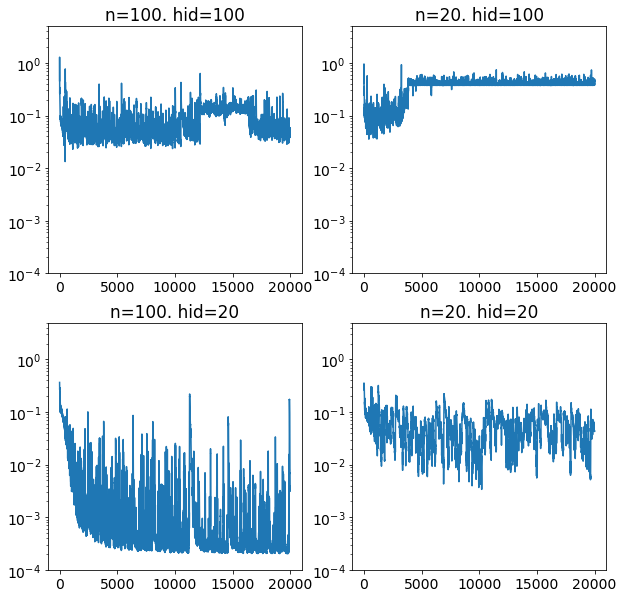

In [73]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax = ax.flatten()
for k, (n, N_hid) in enumerate(zip(ns, N_hids)):
    ax[k].semilogy(loss_test[k, :], label='Validation')
    ax[k].set_title(f'n={ns[k]}. hid={N_hids[k]}')
    ax[k].set_ylim([1e-4, 5])
fig.tight_layout



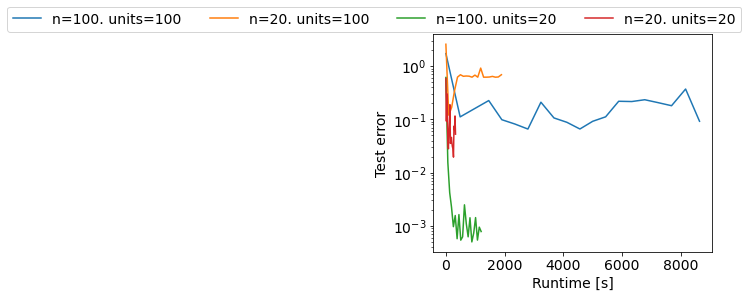

In [53]:
fig, ax = plt.subplots(figsize=(5,4))
for k, (n, N_hid) in enumerate(zip(ns, N_hids)):
    ax.semilogy(runtime[k, ::1000], loss_validation[k, ::1000], label=f'n={n}. units={N_hid}')
ax.set_xlabel('Runtime [s]')
ax.set_ylabel('Test error')
fig.legend(ncol=4)


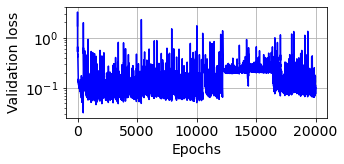

In [88]:
fig, ax = plt.subplots(figsize=(5,2.5))
#ax.semilogy(loss_train[0, :e], color='red', alpha=1, label='Training')
ax.semilogy(loss_validation[0, :e], color='blue')
#ax.semilogy(loss_data[:e], color='green', alpha=0.5, label='Test')
ax.set_ylabel('Validation loss')
ax.set_xlabel('Epochs')
ax.grid()
fig.tight_layout()
fig.savefig('./figs/burger_full_capacity_loss.png', dpi=600, bbox_inches='tight')

In [76]:
len(nets_runtime)

4

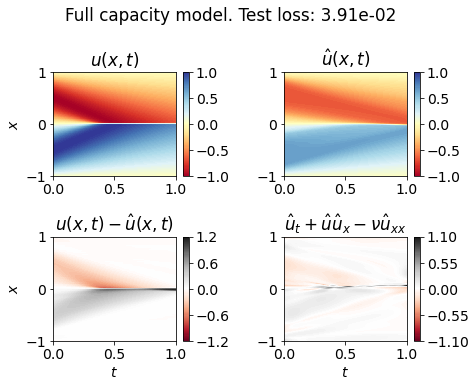

In [78]:
## Evaluate network
fig, axs = plt.subplots(2,2,figsize=(7,5.5))
axs = axs.flatten()
u_hat = nets_runtime[0](x_eval, t_eval).detach().reshape(u_.shape)
pde_hat = net.PDE(x_eval, t_eval).detach().reshape(u_.shape)
vmin = -1 # u_hat.min()
vmax = 1 # u_hat.max()

levels = torch.linspace(vmin, vmax, 100)
c_levels = torch.linspace(vmin, vmax, 5)

m = axs[0].contourf(t_.detach(), x_.detach(), u_.detach(), levels=levels, cmap='RdYlBu')
cb = fig.colorbar(m, ax=axs[0])
cb.set_ticks(c_levels)
axs[0].set_title(r'$u(x,t)$')
# axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$x$')

m = axs[1].contourf(t_.detach(), x_.detach(), u_hat.detach(), levels=levels, cmap='RdYlBu')
cb = fig.colorbar(m, ax=axs[1])
cb.set_ticks(c_levels)
axs[1].set_title(r'$\hat{u}(x,t)$')
# axs[1].set_xlabel('$t$')
# axs[1].set_ylabel('$x$')

vmin = -np.round((u_-u_hat).abs().max(),1)
vmax = -vmin
levels = torch.linspace(vmin, vmax, 100)
c_levels = torch.linspace(vmin, vmax, 5)

m = axs[2].contourf(t_.detach(), x_.detach(), (u_-u_hat).detach(), levels=levels, cmap='RdGy')
cb = fig.colorbar(m, ax=axs[2])
cb.set_ticks(c_levels)
axs[2].set_title(r'$u(x,t) - \hat{u}(x,t)$')
axs[2].set_xlabel('$t$')
axs[2].set_ylabel('$x$')

vmin = -np.round(pde_hat.abs().max(),1)
vmax = -vmin
levels = torch.linspace(vmin, vmax, 100)
c_levels = torch.linspace(vmin, vmax, 5)
m = axs[3].contourf(t_.detach(), x_.detach(), pde_hat.detach(), vmin=vmin, vmax=vmax, levels=levels, cmap='RdGy')
cb = fig.colorbar(m, ax=axs[3])
cb.set_ticks(c_levels)
axs[3].set_title(r'$\hat{u}_t +\hat{u}\hat{u}_x - \nu \hat{u}_{xx}$')
axs[3].set_xlabel('$t$')
# axs[3].set_ylabel('$x$')

fig.suptitle(r'Full capacity model. Test loss: {:.2e}'.format(torch.mean((u_-u_hat).detach()**2)))
fig.tight_layout()
fig.savefig('./figs/burger_full_capacity_2D.png', dpi=600)



